HW1 - Decision Tree

本次作業為預測角色是否死亡 (繳交期限：10/15 23:55)

資料集在以下網址:

https://www.kaggle.com/mylesoneill/game-of-thrones

其中第二份資料的character-deaths.csv

其中三個欄位 Death Year , Book of Death , Death Chapter 取其中一個欄位當預測目標用即可

請將欄位的空值轉成0(代表存活)，有數值的轉成1(代表死亡)


作業流程&要求 ※請使用python處理，可以使用任何套件

1)將資料讀取進來(可用pandas套件)

2)資料前處理

 2-1把空值以0替代

 2-2Death Year , Book of Death , Death Chapter三者取一個，將有數值的轉成1

 2-3將Allegiances轉成dummy特徵(底下有幾種分類就會變成幾個特徵，值是0或1，本來的資料集就會再增加約20種特徵)

 2-4亂數拆成訓練集(75%)與測試集(25%) 

3)使用scikit-learn的DecisionTreeClassifier進行預測(可以先試著將網頁範例(iris)跑出來在使用這次作業的資料集)

4)做出Confusion Matrix，並計算Precision, Recall, Accuracy (提示: 可使用sklearn.metrics)

5)產出決策樹的圖

  p.s 記得限制樹的深度，以免結果無法顯示

 

請將(4)(5)的結果截圖上傳(word 或 PDF)，並上傳python程式碼。

可以嘗試改善資料前處理部分&調整決策樹參數以增加Accuracy
 

要上傳的東西:

1.Word/PDF(截圖跟簡短說明、討論等等)

2.Python程式碼(.py檔)

 

有任何問題請email聯繫助教

 

參考:

1. 推薦用Anaconda安裝python環境，包含Jupyter Notebook、Spyder等IDE以及相關套件

2. scikit-learn上的決策樹教學

http://scikit-learn.org/stable/modules/tree.html

3. 若(5)graphviz發生問題，請試試看conda install graphviz並重啟IDE

https://stackoverflow.com/questions/28312534/graphvizs-executables-are-not-found-python-3-4



In [2]:
"""
1)將資料讀取進來(可用pandas套件)
"""
# loading package
#並合併train&test data
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline
sns.set(font_scale=1.56)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV

# loading data
data = pd.read_csv("character-deaths.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                917 non-null    object 
 1   Allegiances         917 non-null    object 
 2   Death Year          305 non-null    float64
 3   Book of Death       307 non-null    float64
 4   Death Chapter       299 non-null    float64
 5   Book Intro Chapter  905 non-null    float64
 6   Gender              917 non-null    int64  
 7   Nobility            917 non-null    int64  
 8   GoT                 917 non-null    int64  
 9   CoK                 917 non-null    int64  
 10  SoS                 917 non-null    int64  
 11  FfC                 917 non-null    int64  
 12  DwD                 917 non-null    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 93.3+ KB


In [ ]:
# 觀察資料型態、關聯性、等各式統計資料 in "your_report.html"
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title='Pandas Profiling Report')
profile.to_file("your_report.html")

In [3]:
"""
2)資料前處理
"""
# Column Name中的空格用"_"替代
# DataFrame.columns 
# print(data.columns)
# >>>Index(['Name', 'Allegiances', 'Death Year', 'Book of Death', 'Death Chapter',
#        'Book Intro Chapter', 'Gender', 'Nobility', 'GoT', 'CoK', 'SoS', 'FfC',
#        'DwD'],
#       dtype='object')

def clean_col(col):
    col = col.replace(" ","_")
    col = col.lower()
    return col

#Used a loop to apply the function to each item in the index object and assign it back to 
#the DataFrame.columns attribute.
new_columns = []
for c in data.columns:
    clean_c = clean_col(c)
    new_columns.append(clean_c)

data.columns = new_columns
print(data.columns)

Index(['name', 'allegiances', 'death_year', 'book_of_death', 'death_chapter',
       'book_intro_chapter', 'gender', 'nobility', 'got', 'cok', 'sos', 'ffc',
       'dwd'],
      dtype='object')


In [6]:
data["death_year"].unique()

array([ nan, 299., 300., 298., 297.])

In [7]:
data["book_of_death"].unique()  
# nan前面沒有空格、unique值分僅5組，且空值佔比為三者中最低(見統計文件:your_report.html)→選用

array([nan,  3.,  5.,  4.,  2.,  1.])

In [8]:
data["death_chapter"].unique() 

array([nan, 51., 20., 35., 56.,  4., 46., 10., 34., 47., 41., 21., 33.,
       39., 52., 37., 24., 31., 27., 62., 65.,  7., 49., 50., 42., 30.,
       66., 64., 29.,  0., 53., 58., 76., 63., 55., 14., 61., 12., 68.,
       69., 80., 36.,  1., 19., 72., 59., 43., 70., 75., 11.,  3., 60.,
       26., 44., 67., 45., 18., 23., 57., 25., 16., 17., 48.,  9.,  2.,
        6., 32., 77., 74., 40., 38., 73.])

In [4]:
# 2-1把空值以0替代
for i in data:
    data[i] = data[i].fillna(0)
data.info()
#利用 info() ，確認不存在空值

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917 entries, 0 to 916
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                917 non-null    object 
 1   allegiances         917 non-null    object 
 2   death_year          917 non-null    float64
 3   book_of_death       917 non-null    float64
 4   death_chapter       917 non-null    float64
 5   book_intro_chapter  917 non-null    float64
 6   gender              917 non-null    int64  
 7   nobility            917 non-null    int64  
 8   got                 917 non-null    int64  
 9   cok                 917 non-null    int64  
 10  sos                 917 non-null    int64  
 11  ffc                 917 non-null    int64  
 12  dwd                 917 non-null    int64  
dtypes: float64(4), int64(7), object(2)
memory usage: 93.3+ KB


In [5]:
#2-2Death Year , Book of Death , Death Chapter三者中取 book_of_death，將有數值的轉成1

data["book_of_death"].loc[data["book_of_death"]!=0] =1

data["book_of_death"].unique()

C:\Users\User\.conda\envs\env_name\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


array([0., 1.])

In [6]:
data.head()

,name,allegiances,death_year,book_of_death,death_chapter,book_intro_chapter,gender,nobility,got,cok,sos,ffc,dwd
0,Addam Marbrand,Lannister,0.0,0.0,0.0,56.0,1,1,1,1,1,1,0
1,Aegon Frey (Jinglebell),None,299.0,1.0,51.0,49.0,1,1,0,0,1,0,0
2,Aegon Targaryen,House Targaryen,0.0,0.0,0.0,5.0,1,1,0,0,0,0,1
3,Adrack Humble,House Greyjoy,300.0,1.0,20.0,20.0,1,1,0,0,0,0,1
4,Aemon Costayne,Lannister,0.0,0.0,0.0,0.0,1,1,0,0,1,0,0


In [7]:
# 2-3將Allegiances轉成dummy特徵(底下有幾種分類就會變成幾個特徵，值是0或1，本來的資料集就會再增加約20種特徵)
# "allegiances" 提出再 Dummy:Series.str.get_dummies(*args, **kwargs)
data_dummy = data.copy()
X1 = data_dummy.iloc[:,5:]
X2 = data_dummy["allegiances"]

dummies = pd.get_dummies(X2, prefix="allegiances" ) 
data_get_dummy = pd.concat( [X1, dummies], axis = 1 )
data_get_dummy.head()

,book_intro_chapter,gender,nobility,got,cok,sos,ffc,dwd,allegiances_Arryn,allegiances_Baratheon,...,allegiances_House Tyrell,allegiances_Lannister,allegiances_Martell,allegiances_Night's Watch,allegiances_None,allegiances_Stark,allegiances_Targaryen,allegiances_Tully,allegiances_Tyrell,allegiances_Wildling
0,56.0,1,1,1,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,49.0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,5.0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20.0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1,1,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [8]:
data_dummy["allegiances"].unique()
# columns = 原特徵 8個 + allegiances_dummy 21個 = 29 columns →正確

array(['Lannister', 'None', 'House Targaryen', 'House Greyjoy',
       'Baratheon', "Night's Watch", 'Arryn', 'House Stark',
       'House Tyrell', 'Tyrell', 'Stark', 'Greyjoy', 'House Lannister',
       'Martell', 'House Martell', 'Wildling', 'Targaryen', 'House Arryn',
       'House Tully', 'Tully', 'House Baratheon'], dtype=object)

In [63]:
# 2-4亂數拆成訓練集(75%)與測試集(25%)

X = data_get_dummy
y = data_dummy['book_of_death']
#載入訓練組及測試組分組套件
from sklearn.model_selection import train_test_split
#設定隨機種子為42，測試集比例佔25%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=42)

#確定train和test資料
print(X_train.shape)
print("-" * 20)
print(X_test.shape)
print("-" * 20)
print(y_train.shape)
print("-" * 20)
y_test.shape

(687, 29)
--------------------
(230, 29)
--------------------
(687,)
--------------------


(230,)

In [66]:
"""
3)使用scikit-learn的DecisionTreeClassifier進行預測(可以先試著將網頁範例(iris)跑出來再使用這次作業的資料集)
"""
from sklearn import tree
from sklearn.metrics import precision_score, recall_score, accuracy_score

X=X_train
y=y_train

#樹深=2
clf_2depth = tree.DecisionTreeClassifier(max_depth=2)
clf_2depth = clf_2depth.fit(X,y)
Y_prediction_2depth = clf_2depth.predict(X_test)

precision2 = precision_score(y_test,Y_prediction_2depth)
recall2 = recall_score(y_test,Y_prediction_2depth)
accuracy2 = accuracy_score(y_test,Y_prediction_2depth)
print("precision_2_depth=",precision2)
print("recall_2_depth=",recall2)
print("accuracy_2_depth=",accuracy2)
print("-" * 40)

#樹深=3
clf_3depth = tree.DecisionTreeClassifier(max_depth=3)
clf_3depth = clf_3depth.fit(X,y)
Y_prediction_3depth = clf_3depth.predict(X_test)

precision3 = precision_score(y_test,Y_prediction_3depth)
recall3 = recall_score(y_test,Y_prediction_3depth)
accuracy3 = accuracy_score(y_test,Y_prediction_3depth)
print("precision_3_depth=",precision3)
print("recall_3_depth=",recall3)
print("accuracy_3_depth=",accuracy3)
print("-" * 40)

#樹深=4
clf_4depth = tree.DecisionTreeClassifier(max_depth=4)
clf_4depth = clf_4depth.fit(X,y)
Y_prediction_4depth = clf_4depth.predict(X_test)

precision4 = precision_score(y_test,Y_prediction_4depth)
recall4 = recall_score(y_test,Y_prediction_4depth)
accuracy4 = accuracy_score(y_test,Y_prediction_4depth)
print("precision_4_depth=",precision4)
print("recall_4_depth=",recall4)
print("accuracy_4_depth=",accuracy4)
print("-" * 40)

#樹深=5
clf_5depth = tree.DecisionTreeClassifier(max_depth=5)
clf_5depth = clf_5depth.fit(X,y)
Y_prediction_5depth = clf_5depth.predict(X_test)

precision5 = precision_score(y_test,Y_prediction_5depth)
recall5 = recall_score(y_test,Y_prediction_5depth)
accuracy5 = accuracy_score(y_test,Y_prediction_5depth)
print("precision_5_depth=",precision5)
print("recall_5_depth=",recall5)
print("accuracy_5_depth=",accuracy5)
print("-" * 40)

#樹深=6
clf_6depth = tree.DecisionTreeClassifier(max_depth=6)
clf_6depth = clf_6depth.fit(X,y)
Y_prediction_6depth = clf_6depth.predict(X_test)

precision6 = precision_score(y_test,Y_prediction_6depth)
recall6 = recall_score(y_test,Y_prediction_6depth)
accuracy6 = accuracy_score(y_test,Y_prediction_6depth)
print("precision_6_depth=",precision6)
print("recall_6_depth=",recall6)
print("accuracy_6_depth=",accuracy6)
print("-" * 40)

#樹深=7
clf_7depth = tree.DecisionTreeClassifier(max_depth=7)
clf_7depth = clf_7depth.fit(X,y)
Y_prediction_7depth = clf_7depth.predict(X_test)

precision7 = precision_score(y_test,Y_prediction_7depth)
recall7 = recall_score(y_test,Y_prediction_7depth)
accuracy7 = accuracy_score(y_test,Y_prediction_7depth)
print("precision_7_depth=",precision7)
print("recall_7_depth=",recall7)
print("accuracy_7_depth=",accuracy7)
print("-" * 40)

#樹深=8
clf_8depth = tree.DecisionTreeClassifier(max_depth=8)
clf_8depth = clf_8depth.fit(X,y)
Y_prediction_8depth = clf_8depth.predict(X_test)

precision8 = precision_score(y_test,Y_prediction_8depth)
recall8 = recall_score(y_test,Y_prediction_8depth)
accuracy8 = accuracy_score(y_test,Y_prediction_8depth)
print("precision_8_depth=",precision8)
print("recall_8_depth=",recall8)
print("accuracy_8_depth=",accuracy8)
print("-" * 40)

precision_2_depth= 0.4594594594594595
recall_2_depth= 0.8225806451612904
accuracy_2_depth= 0.691304347826087
----------------------------------------
precision_3_depth= 0.5063291139240507
recall_3_depth= 0.6451612903225806
accuracy_3_depth= 0.7347826086956522
----------------------------------------
precision_4_depth= 0.5
recall_4_depth= 0.2903225806451613
accuracy_4_depth= 0.7304347826086957
----------------------------------------
precision_5_depth= 0.4878048780487805
recall_5_depth= 0.6451612903225806
accuracy_5_depth= 0.7217391304347827
----------------------------------------
precision_6_depth= 0.5303030303030303
recall_6_depth= 0.5645161290322581
accuracy_6_depth= 0.7478260869565218
----------------------------------------
precision_7_depth= 0.52
recall_7_depth= 0.6290322580645161
accuracy_7_depth= 0.7434782608695653
----------------------------------------
precision_8_depth= 0.4675324675324675
recall_8_depth= 0.5806451612903226
accuracy_8_depth= 0.7086956521739131
--------------

In [58]:
"""
4)做出Confusion Matrix，並計算Precision, Recall, Accuracy (提示: 可使用sklearn.metrics)
"""
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
confusion_matrix(y_test,Y_prediction)

array([[129,  39],
       [ 22,  40]], dtype=int64)

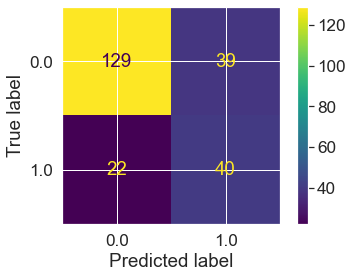

In [59]:
# 叫出圖式化confusion_matrix，確認 TP、TN、FN、FP
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()  

In [60]:
# 計算Precision, Recall, Accuracy
# I.手動計算
Precision = 40/(39+40)
Recall = 40/(22+40)
Accuracy = (129+40)/(129+39+22+40)
print("Precision=",Precision)
print("Recall=",Recall)
print("Accuracy=",Accuracy)

Precision= 0.5063291139240507
Recall= 0.6451612903225806
Accuracy= 0.7347826086956522


In [61]:
# 計算Precision, Recall, Accuracy
# II. 函式計算
from sklearn.metrics import precision_score, recall_score, accuracy_score

precision = precision_score(y_test,Y_prediction)
recall = recall_score(y_test,Y_prediction)
accuracy = accuracy_score(y_test,Y_prediction)
print("precision=",precision)
print("recall=",recall)
print("accuracy=",accuracy)

precision= 0.5063291139240507
recall= 0.6451612903225806
accuracy= 0.7347826086956522


In [67]:
"""
5)產出決策樹的圖 
"""
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("HW1_309708015_周映儀_tree圖") 

'HW1_309708015_周映儀_tree圖.pdf'